# Analysis of Runtime and Solutions

In [2]:
import os
import json
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import matplotlib as mpl
from pprint import pprint

In [3]:
color_wheel = ['#456990', '#EBA947', '#76E5C4', '#EF1A2C', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3']

In [4]:
project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
report_path = f'{project_path}/report/'
machine = 'solstorm'  # solstorm or local
dir_names = ['base_case', 'fleet_size', 'order_composition', 'selection_strategy', 'weather', 'no_speed_opt']

dir_name_to_files = {}
for dir_name in dir_names:
    results_path = f'{project_path}/output/{machine}/{dir_name}/results'

    files = [os.path.join(results_path, f) for f in os.listdir(results_path) 
             if os.path.isfile(os.path.join(results_path, f))]
    
    dir_name_to_files.update({dir_name: files})

In [10]:
def count_installations(results):
    installations = set()
    for order in results['instance_info']['order_composition']:
        installations.add(results['instance_info']['order_composition'][order]['installation'])
    return len(installations)

def make_runtime_df(files, sortby):
    columns = ['Instance name', 'Orders', 'Vessels', 'Installations',
               'Weather', 'Selection', 'Optimality gap', 'Variables', 'Arcs', 
               'Preprocess runtime', 'Model runtime']
    rows = []
    for file in files:
        file_name = os.path.basename(file).split('.')[0]
        with open(file) as file:
            results = json.load(file)
        orders = len(results['order_fulfillment']['postponed_orders']) + len(results['order_fulfillment']['serviced_orders'])
        installations = count_installations(results)
        category = file_name.split('-')[1]
        selection = 'Clustered' if category == 'CL' else 'Even' if category == 'ES' else 'Random'
        row = [file_name,
               orders,
               results['instance_info']['fleet_size'],
               installations,
               results['instance_info']['weather_scenario']+1,
               selection,
               results['objective']['optimality_gap'],
               results['variables']['number_of_variables'],
               results['variables']['number_of_arcs'],
               results['runtime']['preprocess_runtime'],
               results['runtime']['model_runtime']]
        rows.append(row)
    runtime_df = pd.DataFrame(rows, columns=columns)
    runtime_df = runtime_df.sort_values(sortby)
    runtime_df.reset_index(drop=True, inplace=True)
    return runtime_df

# pd.set_option("display.max_rows", None, "display.max_columns", None)

bc_runtime_df = make_runtime_df(dir_name_to_files['base_case'], ['Orders'])
fs_runtime_df = make_runtime_df(dir_name_to_files['fleet_size'], ['Vessels', 'Orders', 'Instance name'])
fs_runtime_small_df = fs_runtime_df[fs_runtime_df['Orders'].isin([4, 6, 8])]
fs_runtime_medium_df = fs_runtime_df[fs_runtime_df['Orders'].isin([10, 12, 14])]
oc_runtime_df = make_runtime_df(dir_name_to_files['order_composition'], ['Orders','Instance name'])
ss_runtime_df = make_runtime_df(dir_name_to_files['selection_strategy'], ['Orders','Instance name'])
ws_runtime_df = make_runtime_df(dir_name_to_files['weather'], ['Weather', 'Orders','Instance name'])
nso_runtime_df = make_runtime_df(dir_name_to_files['no_speed_opt'], ['Orders', 'Instance name'])

nso_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-C1-V1-WS0,4,1,2,1,Random,0.000000,4186,4150,0.2624,0.4326
1,O4-C2-V1-WS0,4,1,2,1,Random,0.000000,2808,2772,0.2645,0.1789
2,O4-C3-V1-WS0,4,1,2,1,Random,0.000000,4244,4208,0.2538,0.2900
3,O4-C4-V1-WS0,4,1,2,1,Random,0.000000,3978,3942,0.2384,0.2981
4,O6-C1-V1-WS0,6,1,3,1,Random,0.000000,6864,6816,0.5658,0.9346
5,O6-C2-V1-WS0,6,1,3,1,Random,0.000000,6698,6650,0.5638,0.6782
6,O6-C3-V1-WS0,6,1,3,1,Random,0.000000,8752,8704,0.5709,1.1825
7,O6-C4-V1-WS0,6,1,3,1,Random,0.000000,8382,8334,0.5484,0.9446
8,O8-C1-V1-WS0,8,1,4,1,Random,0.000000,12520,12460,0.9935,3.8901
9,O8-C2-V1-WS0,8,1,4,1,Random,0.000000,12106,12046,0.9910,2.3483


In [11]:
def mean(x):
    return sum(x) / len(x)

def aggregate_runtime_df(df, groupby):
    agg_runtime_df = df.groupby(groupby).agg(gap=pd.NamedAgg(column='Optimality gap', 
                                                             aggfunc=mean),
                                             variables=pd.NamedAgg(column='Variables',
                                                                   aggfunc=mean),
                                             arcs=pd.NamedAgg(column='Arcs',
                                                              aggfunc=mean),
                                             preprocess_runtime=pd.NamedAgg(column='Preprocess runtime', 
                                                                            aggfunc=mean),
                                             model_runtime=pd.NamedAgg(column='Model runtime',
                                                                       aggfunc=mean))
    agg_runtime_df.variables = agg_runtime_df.variables.astype(int)
    agg_runtime_df.arcs = agg_runtime_df.arcs.astype(int)
    old_to_new_names = {'gap': 'Optimality gap', 
                        'variables': 'Variables',
                        'arcs': 'Arcs',
                        'preprocess_runtime': 'Preprocess runtime',
                        'model_runtime': 'Model runtime'}
    agg_runtime_df = agg_runtime_df.rename(columns=old_to_new_names)
    return agg_runtime_df

bc_agg_runtime_df = aggregate_runtime_df(bc_runtime_df, ['Orders'])
fs_agg_runtime_small_df = aggregate_runtime_df(fs_runtime_small_df, ['Orders', 'Vessels'])
fs_agg_runtime_medium_df = aggregate_runtime_df(fs_runtime_medium_df, ['Orders', 'Vessels'])
ws2_agg_runtime_df = aggregate_runtime_df(ws_runtime_df.loc[ws_runtime_df['Weather'] == 2], ['Orders'])
ws3_agg_runtime_df = aggregate_runtime_df(ws_runtime_df.loc[ws_runtime_df['Weather'] == 3], ['Orders'])
sse_runtime_df = ss_runtime_df.loc[ss_runtime_df['Selection'] == 'Even']
sse_runtime_df = sse_runtime_df.set_index('Orders')
ssc_runtime_df = ss_runtime_df.loc[ss_runtime_df['Selection'] == 'Clustered']
ssc_runtime_df = ssc_runtime_df.set_index('Orders')
nso_agg_runtime_df = aggregate_runtime_df(nso_runtime_df, ['Orders'])

nso_agg_runtime_df

,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,
4,0.000000,3804,3768,0.254775,0.299900
6,0.000000,7674,7626,0.562225,0.934975
8,0.000000,13390,13330,1.019100,3.171475
10,0.000000,30127,30019,2.287850,33.893225
12,0.000000,43653,43527,3.521350,58.635800
14,0.000000,59558,59414,4.627575,117.968025
16,0.000000,103174,102958,7.874125,732.460850
18,0.023978,128152,127912,9.990475,2248.531200
20,0.101162,159232,158968,12.465000,3600.333600


In [12]:
def make_solutions_df(files, sortby):
    columns = ['Instance name', 'Orders', 'Serviced', 'Postponed', 
               'Vessels', 'Fleet', 'Chartered', 'Weather', 'Selection',
               'Fuel costs', 'Charter costs', 'Penalty costs', 'Objective bound']
    rows = []
    for file in files:
        file_name = os.path.basename(file).split('.')[0]
        with open(file) as file:
            results = json.load(file)
        orders = len(results['order_fulfillment']['postponed_orders']) + len(results['order_fulfillment']['serviced_orders'])
        selection = 'Clustered' if file_name.split('-')[1] == 'CL' else 'Even' if file_name.split('-')[1] == 'ES' else 'Random'
        row = [file_name,
               orders,
               len(results['order_fulfillment']['serviced_orders']),
               len(results['order_fulfillment']['postponed_orders']),  
               results['instance_info']['fleet_size'],
               results['vessels']['fleet_vessels'], 
               results['vessels']['chartered_vessels'],
               results['instance_info']['weather_scenario']+1,
               selection,
               results['objective']['fuel_costs'], 
               results['objective']['charter_costs'], 
               abs(results['objective']['penalty_costs']),
               results['objective']['objective_bound']]
        rows.append(row)
    solutions_df = pd.DataFrame(rows, columns=columns)
    solutions_df = solutions_df.sort_values(sortby)
    solutions_df.reset_index(drop=True, inplace=True)
    return solutions_df

bc_solutions_df = make_solutions_df(dir_name_to_files['base_case'], ['Orders', 'Instance name'])
fs_solutions_df = make_solutions_df(dir_name_to_files['fleet_size'], ['Orders', 'Vessels', 'Instance name'])
fs_solutions_small_df = fs_solutions_df[fs_solutions_df['Orders'].isin([4, 6, 8])]
fs_solutions_medium_df = fs_solutions_df[fs_solutions_df['Orders'].isin([10, 12, 14])]
oc_solutions_df = make_solutions_df(dir_name_to_files['order_composition'], ['Orders', 'Instance name'])
ss_solutions_df = make_solutions_df(dir_name_to_files['selection_strategy'], ['Orders', 'Instance name'])
ws_solutions_df = make_solutions_df(dir_name_to_files['weather'], ['Orders', 'Instance name'])
nso_solutions_df = make_solutions_df(dir_name_to_files['no_speed_opt'], ['Orders', 'Instance name'])

nso_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O4-C1-V1-WS0,4,4,0,1,1,0,1,Random,2488.14,0.0,0.0000,2488.1400
1,O4-C2-V1-WS0,4,4,0,1,1,0,1,Random,2902.14,0.0,0.0000,2902.1400
2,O4-C3-V1-WS0,4,4,0,1,1,0,1,Random,2534.37,0.0,0.0000,2534.3700
3,O4-C4-V1-WS0,4,4,0,1,1,0,1,Random,2954.58,0.0,0.0000,2954.5800
4,O6-C1-V1-WS0,6,6,0,1,1,0,1,Random,2666.85,0.0,0.0000,2666.8500
5,O6-C2-V1-WS0,6,6,0,1,1,0,1,Random,3125.70,0.0,0.0000,3125.7000
6,O6-C3-V1-WS0,6,6,0,1,1,0,1,Random,2935.95,0.0,0.0000,2935.9500
7,O6-C4-V1-WS0,6,6,0,1,1,0,1,Random,3184.35,0.0,0.0000,3184.3500
8,O8-C1-V1-WS0,8,8,0,1,1,0,1,Random,2764.14,0.0,0.0000,2764.1400
9,O8-C2-V1-WS0,8,8,0,1,1,0,1,Random,3166.41,0.0,0.0000,3166.4100


In [13]:
def mean(x):
    return sum(x) / len(x)

def aggregate_solutions_df(df, groupby):
    agg_solutions_df = df.groupby(groupby).agg(serviced=pd.NamedAgg(column='Serviced',
                                                                    aggfunc=mean),
                                               postponed=pd.NamedAgg(column='Postponed',
                                                                     aggfunc=mean),
                                               fleet_vessels=pd.NamedAgg(column='Fleet',
                                                                         aggfunc=mean),
                                               charter_vessels=pd.NamedAgg(column='Chartered',
                                                                           aggfunc=mean),
                                               fuel_costs=pd.NamedAgg(column='Fuel costs',
                                                                      aggfunc=mean),
                                               charter_costs=pd.NamedAgg(column='Charter costs',
                                                                         aggfunc=mean),
                                               penalty_costs=pd.NamedAgg(column='Penalty costs',
                                                                         aggfunc=mean),
                                               objective_bound=pd.NamedAgg(column='Objective bound',
                                                                           aggfunc=mean))
    old_to_new_names = {'serviced': 'Serviced',
                      'postponed': 'Postponed',
                      'fleet_vessels': 'Fleet',
                      'charter_vessels': 'Chartered',
                      'fuel_costs': 'Fuel costs',
                      'charter_costs': 'Charter costs',
                      'penalty_costs': 'Penalty costs',
                      'objective_bound': 'Objective bound'}
    agg_solutions_df = agg_solutions_df.rename(columns=old_to_new_names)
    return agg_solutions_df

bc_agg_solutions_df = aggregate_solutions_df(bc_solutions_df, ['Orders'])
fs_agg_solutions_small_df = aggregate_solutions_df(fs_solutions_small_df, ['Vessels'])
fs_agg_solutions_medium_df = aggregate_solutions_df(fs_solutions_medium_df, ['Vessels'])
ws_agg_solutions_df = aggregate_solutions_df(ws_solutions_df, ['Orders', 'Weather'])
ss_agg_solutions_df = aggregate_solutions_df(ss_solutions_df, ['Orders', 'Selection'])
nso_agg_solutions_df = aggregate_solutions_df(nso_solutions_df, ['Orders'])

nso_agg_solutions_df

,Serviced,Postponed,Fleet,Chartered,Fuel costs,Charter costs,Penalty costs,Objective bound
Orders,,,,,,,,
4,4,0,1.00,0,2719.8075,0.0,0.000000,2719.807500
6,6,0,1.00,0,2978.2125,0.0,0.000000,2978.212500
8,8,0,1.00,0,3161.9250,0.0,0.000000,3161.925000
10,10,0,2.00,0,4595.9175,0.0,0.000000,4595.917500
12,12,0,2.00,0,4931.0850,0.0,0.000000,4931.085000
14,14,0,2.00,0,5278.5000,0.0,0.000125,5278.499875
16,16,0,2.25,0,6051.8175,0.0,0.001000,6051.816500
18,18,0,2.50,0,6436.3200,0.0,0.000325,6256.343125
20,20,0,2.75,0,6822.7200,0.0,0.000975,6031.001400


In [24]:
def plot_columns(df, columns, x_label, y_label, fig, ax, mode, 
                 super_color=None, os=None, ws=None, ss=None, ls=None, nso=None):    
    linewidth = 1.8
    alpha = 0.9
    
    X, Y, colors, labels = [], [], [], []
    if mode == 'base_case':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[column]):
                x.append(int(df[df == value].index[i]))
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice if not super_color else super_color)
            labels.append(column)
    
    elif mode == 'fleet_size':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[columns[0]]):
                x.append(int(df[df == value].index[i]))
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice if not super_color else super_color)
            runtime = columns[0].split(' ')[1].capitalize()
            labels.append(f'{os} orders')
                
    elif mode == 'order_composition':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[column]):
                x.append(df.loc[i, 'Installations'])
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice)
            labels.append(column)
    
    elif mode == 'weather':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[column]):
                x.append(int(df[df == value].index[i]))
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice if not super_color else super_color)
            labels.append(f'Weather scenario {ws}')
    
    elif mode == 'selection_strategy':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[column]):
                x.append(int(df[df == value].index[i]))
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice if not super_color else super_color)
            labels.append(f'Selection strategy {ss}')
    
    elif mode == 'no_speed_opt':
        for color_choice, column in enumerate(columns):
            x, y = [], []
            for i, value in enumerate(df[column]):
                x.append(int(df[df == value].index[i]))
                y.append(value)
            X.append(x)
            Y.append(y)
            colors.append(color_choice if not super_color else super_color)
            labels.append(nso)
    
    for x, y, c, label in zip(X, Y, colors, labels):
        ax.plot(x,
                y,
                color=color_wheel[c],
                linestyle='-' if not ls else ls,
                lw=linewidth if not ls else linewidth * 0.8,
                label=label,
                alpha=alpha)
    return fig, ax

def plot_sub_dfs(df, columns, x_label, y_label, fig, ax, mode):
    orders, vessels = set(), set()
    for o, v in list(df.index):
        orders.add(o)
        vessels.add(v)
        
    for order in orders:
        if order in [4, 10]:
            color = 0
        elif order in [6, 12]:
            color = 2
        elif order in [8, 14]:
            color = 1
        sub_df = df.loc[order]
        plot_columns(sub_df, columns, x_label, y_label, fig, ax, os=order, mode=mode, super_color=color)
    
    if min(vessels) != 1:
        ax.plot(list(vessels), 
                [3600 for _ in range(len(list(vessels)))],
                color=color_wheel[3],
                linestyle='dashed',
                lw=1.3,
                label='Max runtime',
                alpha=1)
    
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.major.formatter._useMathText = True
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.locator_params(integer=True)
        ax.legend(frameon=False, bbox_to_anchor=(0.015, 0.96), loc='upper left', ncol=1, handlelength=4)
        # plt.savefig('Fleet_size_runtime_1.jpg', dpi=400)
    else:    
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.major.formatter._useMathText = True
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.locator_params(integer=True)
        ax.legend(frameon=False, loc='best', ncol=1, handlelength=4)
        # plt.savefig('Fleet_size_runtime_2.jpg', dpi=400)
    return fig, ax
    
def plot_bc_runtime():
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Preprocess runtime', 'Model runtime']
    x_label = 'Orders (#)'
    y_label = 'Runtime (s)'
    fig, ax = plot_columns(bc_agg_runtime_df, columns, x_label, y_label, fig, ax, mode='base_case')
    ax.plot([i for i in range(4, 17, 2)], 
            [3600 for _ in range(4, 17, 2)],
            color=color_wheel[3],
            linestyle='dashed',
            lw=1.3,
            label='Max runtime',
            alpha=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    ax.legend(frameon=False, loc='best', ncol=1, handlelength=4)
    # plt.savefig('Base_case_runtime.jpg', dpi=400)
    plt.show()

def plot_fs_runtime(df):
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Model runtime']
    x_label = 'Vessels (#)'
    y_label = 'Runtime (s)'
    # fig, ax = plot_columns(fs_ag_runtime_selected_df, columns, x_label, y_label, fig, ax, mode='fleet_size')
    fig, ax = plot_sub_dfs(df, columns, x_label, y_label, fig, ax, mode='fleet_size')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    plt.show()
    
def plot_oc_runtime():
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Model runtime']
    x_label = 'Installations (#)'
    y_label = 'Runtime (s)'
    fig, ax = plot_columns(oc_runtime_df, columns, x_label, y_label, fig, ax, mode='order_composition')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    # plt.savefig('Order_composition.jpg', dpi=400)
    plt.show()
    
def plot_ws_runtime():
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Model runtime']
    x_label = 'Orders (#)'
    y_label = 'Runtime (s)'
    fig, ax = plot_columns(bc_agg_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='weather', super_color=0, ws='None')
    fig, ax = plot_columns(ws2_agg_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='weather', super_color=1, ws='Low', ls='dashdot')
    fig, ax = plot_columns(ws3_agg_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='weather', super_color=2, ws='High')
    ax.plot([i for i in range(4, 27, 2)], 
            [3600 for _ in range(4, 27, 2)],
            color=color_wheel[3],
            linestyle='dashed',
            lw=1.3,
            label='Max runtime',
            alpha=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    ax.legend(frameon=False, loc='best', ncol=1, handlelength=4)
    # plt.savefig('Weather_scenarios_runtime.jpg', dpi=400)
    plt.show()
    
def plot_ss_runtime():
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Model runtime']
    x_label = 'Orders (#)'
    y_label = 'Runtime (s)'
    fig, ax = plot_columns(bc_agg_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='selection_strategy', super_color=0, ss='Random')
    fig, ax = plot_columns(ssc_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='selection_strategy', super_color=1, ss='Clustering')
    fig, ax = plot_columns(sse_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='selection_strategy', super_color=2, ss='Even spreading')
    ax.plot([i for i in range(4, 19, 2)], 
            [3600 for _ in range(4, 19, 2)],
            color=color_wheel[3],
            linestyle='dashed',
            lw=1.3,
            label='Max runtime',
            alpha=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    ax.legend(frameon=False, loc='best', ncol=1, handlelength=4)
    # plt.savefig('Selection_strategy_runtime.jpg', dpi=400)
    plt.show()
    
def plot_nso_runtime():
    plt.close('all')
    plt.style.use(os.path.join(report_path, 'PaperDoubleFig.mplstyle'))
    fig, ax = plt.subplots()
    columns = ['Model runtime']
    x_label = 'Orders (#)'
    y_label = 'Runtime (s)'
    fig, ax = plot_columns(bc_agg_runtime_df, columns, x_label, y_label, fig, ax, 
                           mode='no_speed_opt', super_color=1, nso='Speed optimization')
    fig, ax = plot_columns(nso_agg_runtime_df, columns, x_label, y_label, fig, ax,
                           mode='no_speed_opt', super_color=0, nso='No speed optimization')
    ax.plot([i for i in range(4, 21, 2)], 
            [3600 for _ in range(4, 21, 2)],
            color=color_wheel[3],
            linestyle='dashed',
            lw=1.3,
            label='Max runtime',
            alpha=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.locator_params(integer=True)
    ax.legend(frameon=False, loc='best', ncol=1, handlelength=4)
    # plt.savefig('No_speed_opt_runtime.jpg', dpi=400)
    plt.show()

## Base case

### Base case runtime

In [215]:
bc_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-C4-V1-WS0,4,1,2,1,Random,0.000000,7094,7058,0.6631,0.7944
1,O4-C2-V1-WS0,4,1,2,1,Random,0.000000,5704,5668,0.7464,0.2344
2,O4-C1-V1-WS0,4,1,2,1,Random,0.000000,7438,7402,0.6901,0.6869
3,O4-C3-V1-WS0,4,1,2,1,Random,0.000000,10612,10576,0.8865,0.8492
4,O6-C4-V1-WS0,6,1,3,1,Random,0.000000,22282,22234,1.7506,2.4134
5,O6-C2-V1-WS0,6,1,3,1,Random,0.000000,16986,16938,1.7737,1.9706
6,O6-C3-V1-WS0,6,1,3,1,Random,0.000000,26360,26312,2.0428,2.8153
7,O6-C1-V1-WS0,6,1,3,1,Random,0.000000,15040,14992,1.7319,1.8183
8,O8-C3-V1-WS0,8,1,4,1,Random,0.000000,47006,46946,3.5939,12.6923
9,O8-C1-V1-WS0,8,1,4,1,Random,0.000000,26936,26876,2.8697,9.0298


#### Base case runtime aggregated

In [216]:
bc_agg_runtime_df

,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,
4,0.00000,7712,7676,0.746525,0.641225
6,0.00000,20167,20119,1.824750,2.254400
8,0.00000,36576,36516,3.182200,9.609525
10,0.00000,88290,88182,7.454525,93.534975
12,0.00000,132921,132795,10.673075,221.402100
14,0.00000,185856,185712,14.690950,507.533425
16,0.12722,339024,338808,25.744200,3600.167925


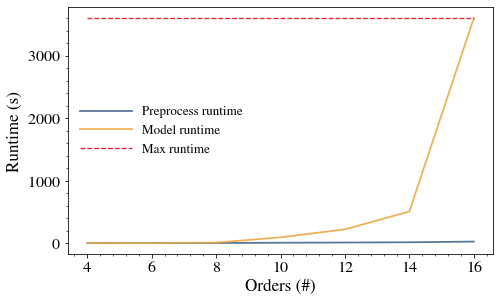

In [217]:
plot_bc_runtime()

### Base case solutions

In [218]:
bc_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O4-C1-V1-WS0,4,4,0,1,1,0,1,Random,1768.4317,0.0,0.0000,1768.4317
1,O4-C2-V1-WS0,4,4,0,1,1,0,1,Random,2079.8900,0.0,0.0000,2079.8900
2,O4-C3-V1-WS0,4,4,0,1,1,0,1,Random,1849.5450,0.0,0.0000,1849.5450
3,O4-C4-V1-WS0,4,4,0,1,1,0,1,Random,2173.7300,0.0,0.0000,2173.7300
4,O6-C1-V1-WS0,6,6,0,1,1,0,1,Random,1969.3367,0.0,0.0000,1969.3367
5,O6-C2-V1-WS0,6,6,0,1,1,0,1,Random,2268.5667,0.0,0.0000,2268.5667
6,O6-C3-V1-WS0,6,6,0,1,1,0,1,Random,2159.5083,0.0,0.0000,2159.5083
7,O6-C4-V1-WS0,6,6,0,1,1,0,1,Random,2351.1750,0.0,0.0000,2351.1750
8,O8-C1-V1-WS0,8,8,0,1,1,0,1,Random,2066.8088,0.0,0.0000,2066.8088
9,O8-C2-V1-WS0,8,8,0,1,1,0,1,Random,2350.6767,0.0,0.0000,2350.6767


#### Base case solutions aggregated

In [219]:
bc_agg_solutions_df

,Serviced,Postponed,Fleet,Chartered,Fuel costs,Charter costs,Penalty costs,Objective bound
Orders,,,,,,,,
4,4,0,1.00,0,1967.899175,0.0,0.000000,1967.899175
6,6,0,1.00,0,2187.146675,0.0,0.000000,2187.146675
8,8,0,1.00,0,2352.492725,0.0,0.000000,2352.492725
10,10,0,2.00,0,3523.959375,0.0,0.000000,3523.959350
12,12,0,2.00,0,3726.512700,0.0,0.000475,3726.512225
14,14,0,2.00,0,3969.810800,0.0,0.000525,3969.810275
16,16,0,2.25,0,4565.704850,0.0,0.001100,3859.869625


## Fleet size

### Fleet size runtime

In [220]:
fs_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-C1-V1-WS0,4,1,2,1,Random,0.000000,7438,7402,0.6901,0.6869
1,O4-C2-V1-WS0,4,1,2,1,Random,0.000000,5704,5668,0.7464,0.2344
2,O4-C3-V1-WS0,4,1,2,1,Random,0.000000,10612,10576,0.8865,0.8492
3,O4-C4-V1-WS0,4,1,2,1,Random,0.000000,7094,7058,0.6631,0.7944
4,O6-C1-V1-WS0,6,1,3,1,Random,0.000000,15040,14992,1.7319,1.8183
...,...,...,...,...,...,...,...,...,...,...,...
91,O12-C4-V5-WS0,12,5,6,1,Random,0.000000,296742,296490,21.9175,2505.7260
92,O14-C1-V5-WS0,14,5,7,1,Random,0.165461,358212,357924,29.5577,3600.6089
93,O14-C2-V5-WS0,14,5,7,1,Random,0.200215,345102,344814,28.5504,3600.1430
94,O14-C3-V5-WS0,14,5,7,1,Random,0.211662,376932,376644,31.2173,3600.3764


#### Fleet size runtime aggregated

In [221]:
fs_agg_runtime_small_df

Optimality gap  Variables   Arcs  Preprocess runtime  \
Orders Vessels                                                         
4      1                   0.0       7712   7676            0.746525   
       2                   0.0      11592  11538            1.140150   
       3                   0.0      15429  15357            1.465475   
       4                   0.0      19335  19245            1.777250   
6      1                   0.0      20167  20119            1.824750   
       2                   0.0      30372  30300            2.660100   
       3                   0.0      40315  40219            3.515125   
       4                   0.0      50467  50347            4.362800   
8      1                   0.0      36576  36516            3.182200   
       2                   0.0      54717  54627            4.614000   
       3                   0.0      73208  73088            6.069650   
       4                   0.0      91420  91270            9.322875   

                Model runtime  
Orders Vessels                 
4      1             0.641225  
       2             2.083150  
       3             5.771575  
       4             9.834550  
6      1             2.254400  
       2             9.113800  
       3            19.021275  
       4            28.311200  
8      1             9.609525  
       2            35.716775  
       3            89.236550  
       4           288.559650

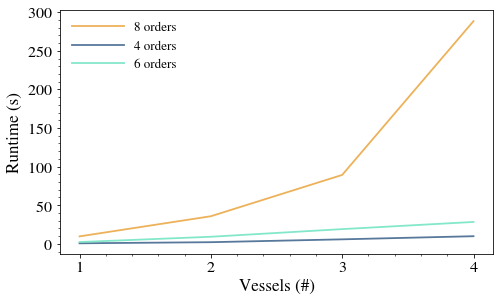

In [249]:
plot_fs_runtime(fs_agg_runtime_small_df)

In [223]:
fs_agg_runtime_medium_df

Optimality gap  Variables    Arcs  Preprocess runtime  \
Orders Vessels                                                          
10     2          0.000000e+00      88290   88182            7.454525   
       3          2.132140e-08     117865  117721            9.989825   
       4          0.000000e+00     146806  146626           12.365750   
       5          0.000000e+00     176109  175893           15.059950   
12     2          0.000000e+00     132921  132795           10.673075   
       3          2.003452e-07     178516  178348           14.424050   
       4          0.000000e+00     221993  221783           18.129300   
       5          5.053436e-02     266754  266502           21.966300   
14     2          0.000000e+00     185856  185712           14.690950   
       3          6.274499e-02     247752  247560           19.486550   
       4          1.333769e-01     310320  310080           24.602150   
       5          2.056389e-01     372310  372022           29.731600   

                Model runtime  
Orders Vessels                 
10     2            93.534975  
       3           329.738050  
       4           507.851550  
       5           885.906050  
12     2           221.402100  
       3          1518.455000  
       4          1924.621425  
       5          2568.529725  
14     2           507.533425  
       3          2127.231200  
       4          3355.573975  
       5          3600.369200

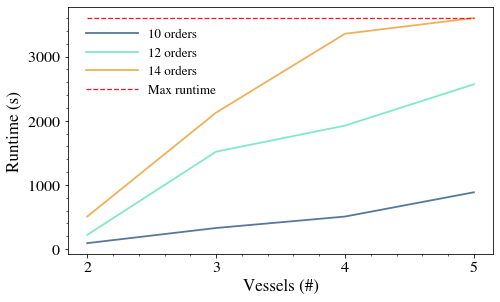

In [250]:
plot_fs_runtime(fs_agg_runtime_medium_df)

### Fleet size solutions

In [225]:
fs_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O4-C1-V1-WS0,4,4,0,1,1,0,1,Random,1768.4317,0.0,0.0000,1768.4317
1,O4-C2-V1-WS0,4,4,0,1,1,0,1,Random,2079.8900,0.0,0.0000,2079.8900
2,O4-C3-V1-WS0,4,4,0,1,1,0,1,Random,1849.5450,0.0,0.0000,1849.5450
3,O4-C4-V1-WS0,4,4,0,1,1,0,1,Random,2173.7300,0.0,0.0000,2173.7300
4,O4-C1-V2-WS0,4,4,0,2,1,0,1,Random,1768.4317,0.0,0.0000,1768.4317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,O14-C4-V4-WS0,14,14,0,4,2,0,1,Random,4123.9671,0.0,0.0023,3432.8487
92,O14-C1-V5-WS0,14,14,0,5,2,0,1,Random,3762.2921,0.0,0.0002,3004.7226
93,O14-C2-V5-WS0,14,14,0,5,2,0,1,Random,3961.1223,0.0,0.0000,3039.7842
94,O14-C3-V5-WS0,14,14,0,5,2,0,1,Random,3922.2571,0.0,0.0010,2918.7669


#### Fleet size solutions aggregated

In [226]:
fs_agg_solutions_small_df

,Serviced,Postponed,Fleet,Chartered,Fuel costs,Charter costs,Penalty costs,Objective bound
Vessels,,,,,,,,
1,6,0,1,0,2169.179525,0.0,0.0,2169.179525
2,6,0,1,0,2185.577408,0.0,0.0,2185.577408
3,6,0,1,0,2178.060083,0.0,0.0,2178.060083
4,6,0,1,0,2176.022025,0.0,0.0,2176.022025


In [227]:
fs_agg_solutions_medium_df

,Serviced,Postponed,Fleet,Chartered,Fuel costs,Charter costs,Penalty costs,Objective bound
Vessels,,,,,,,,
2,12,0,2.000000,0,3740.094292,0.0,0.000333,3740.09395
3,12,0,1.916667,0,3721.596058,0.0,0.000233,3622.70390
4,12,0,2.000000,0,3685.993983,0.0,0.000883,3476.85835
5,12,0,2.000000,0,3682.098350,0.0,0.000675,3289.72245


## Order composition

### Order composition runtime

In [228]:
oc_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O8-I3-V1-WS0,8,1,3,1,Random,0.0,21276,21216,2.1295,3.3109
1,O8-I4-V1-WS0,8,1,4,1,Random,0.0,27330,27270,2.7206,6.6075
2,O8-I5-V1-WS0,8,1,5,1,Random,0.0,42888,42828,3.6553,13.7954
3,O8-I6-V1-WS0,8,1,6,1,Random,0.0,56398,56338,4.8504,26.2674
4,O8-I7-V1-WS0,8,1,7,1,Random,0.0,68174,68114,5.6724,49.3242
5,O8-I8-V1-WS0,8,1,8,1,Random,0.0,82272,82212,6.5923,81.8629


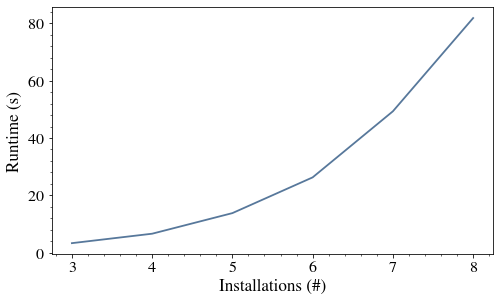

In [229]:
plot_oc_runtime()

### Order composition solutions

In [230]:
oc_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O8-I3-V1-WS0,8,8,0,1,1,0,1,Random,1934.1467,0.0,0.0000,1934.1467
1,O8-I4-V1-WS0,8,8,0,1,1,0,1,Random,1945.8767,0.0,0.0000,1945.8767
2,O8-I5-V1-WS0,8,8,0,1,1,0,1,Random,1985.1971,0.0,0.0000,1985.1971
3,O8-I6-V1-WS0,8,8,0,1,1,0,1,Random,1984.6988,0.0,0.0000,1984.6988
4,O8-I7-V1-WS0,8,8,0,1,1,0,1,Random,2151.9088,0.0,0.0006,2151.9082
5,O8-I8-V1-WS0,8,8,0,1,1,0,1,Random,2295.6588,0.0,0.0015,2295.6573


## Selection strategy

### Selection strategy runtime

In [231]:
ss_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-CL-V1-WS0,4,1,2,1,Clustered,0.000000e+00,4644,4608,0.4603,0.6101
1,O4-ES-V1-WS0,4,1,2,1,Even,0.000000e+00,5646,5610,0.6458,0.2414
2,O6-CL-V1-WS0,6,1,3,1,Clustered,0.000000e+00,10326,10278,1.3119,1.7809
3,O6-ES-V1-WS0,6,1,3,1,Even,0.000000e+00,17746,17698,1.7909,1.9414
4,O8-CL-V1-WS0,8,1,4,1,Clustered,0.000000e+00,21618,21558,2.3688,5.1264
5,O8-ES-V1-WS0,8,1,4,1,Even,0.000000e+00,27360,27300,2.8656,3.3123
6,O10-CL-V2-WS0,10,2,5,1,Clustered,0.000000e+00,49449,49341,5.1939,142.5080
7,O10-ES-V2-WS0,10,2,5,1,Even,0.000000e+00,69606,69498,6.7880,27.5115
8,O12-CL-V2-WS0,12,2,6,1,Clustered,0.000000e+00,63537,63411,7.3950,180.7206
9,O12-ES-V2-WS0,12,2,6,1,Even,0.000000e+00,110754,110628,10.5393,55.4470


#### Selection strategy Even Spreading

In [232]:
sse_runtime_df

,Instance name,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,,,,,,
4,O4-ES-V1-WS0,1,2,1,Even,0.000000,5646,5610,0.6458,0.2414
6,O6-ES-V1-WS0,1,3,1,Even,0.000000,17746,17698,1.7909,1.9414
8,O8-ES-V1-WS0,1,4,1,Even,0.000000,27360,27300,2.8656,3.3123
10,O10-ES-V2-WS0,2,5,1,Even,0.000000,69606,69498,6.7880,27.5115
12,O12-ES-V2-WS0,2,6,1,Even,0.000000,110754,110628,10.5393,55.4470
14,O14-ES-V2-WS0,2,7,1,Even,0.000000,164190,164046,15.2127,282.5966
16,O16-ES-V3-WS0,3,8,1,Even,0.077132,309320,309104,26.8493,3600.1900


#### Selection strategy Clustering

In [233]:
ssc_runtime_df

,Instance name,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,,,,,,
4,O4-CL-V1-WS0,1,2,1,Clustered,0.000000e+00,4644,4608,0.4603,0.6101
6,O6-CL-V1-WS0,1,3,1,Clustered,0.000000e+00,10326,10278,1.3119,1.7809
8,O8-CL-V1-WS0,1,4,1,Clustered,0.000000e+00,21618,21558,2.3688,5.1264
10,O10-CL-V2-WS0,2,5,1,Clustered,0.000000e+00,49449,49341,5.1939,142.5080
12,O12-CL-V2-WS0,2,6,1,Clustered,0.000000e+00,63537,63411,7.3950,180.7206
14,O14-CL-V2-WS0,2,7,1,Clustered,0.000000e+00,94479,94335,9.6385,334.4286
16,O16-CL-V3-WS0,3,8,1,Clustered,5.947778e-07,145220,145004,15.6051,2349.3366
18,O18-CL-V3-WS0,3,9,1,Clustered,1.567558e-01,226360,226120,22.8008,3600.1425


### Selection strategy solutions

In [234]:
ss_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O4-CL-V1-WS0,4,4,0,1,1,0,1,Clustered,1059.9167,0.0,0.0000,1059.9167
1,O4-ES-V1-WS0,4,4,0,1,1,0,1,Even,2163.4950,0.0,0.0000,2163.4950
2,O6-CL-V1-WS0,6,6,0,1,1,0,1,Clustered,1444.2850,0.0,0.0000,1444.2850
3,O6-ES-V1-WS0,6,6,0,1,1,0,1,Even,3178.4850,0.0,0.0000,3178.4850
4,O8-CL-V1-WS0,8,8,0,1,1,0,1,Clustered,1460.6533,0.0,0.0000,1460.6533
5,O8-ES-V1-WS0,8,8,0,1,1,0,1,Even,3308.0133,0.0,0.0000,3308.0133
6,O10-CL-V2-WS0,10,10,0,2,1,0,1,Clustered,1534.1000,0.0,0.0000,1534.1000
7,O10-ES-V2-WS0,10,10,0,2,2,0,1,Even,4190.4850,0.0,0.0000,4190.4850
8,O12-CL-V2-WS0,12,12,0,2,2,0,1,Clustered,2889.8590,0.0,0.0000,2889.8590
9,O12-ES-V2-WS0,12,12,0,2,2,0,1,Even,4343.4733,0.0,0.0000,4343.4733


#### Selection strategy solutions aggregated

In [235]:
ss_agg_solutions_df

Serviced  Postponed  Fleet  Chartered  Fuel costs  \
Orders Selection                                                      
4      Clustered         4          0      1          0   1059.9167   
       Even              4          0      1          0   2163.4950   
6      Clustered         6          0      1          0   1444.2850   
       Even              6          0      1          0   3178.4850   
8      Clustered         8          0      1          0   1460.6533   
       Even              8          0      1          0   3308.0133   
10     Clustered        10          0      1          0   1534.1000   
       Even             10          0      2          0   4190.4850   
12     Clustered        12          0      2          0   2889.8590   
       Even             12          0      2          0   4343.4733   
14     Clustered        14          0      2          0   2847.4383   
       Even             14          0      2          0   4497.4583   
16     Clustered        16          0      3          0   3966.2590   
       Even             16          0      2          0   4734.5500   
18     Clustered        18          0      2          0   3352.0440   

                  Charter costs  Penalty costs  Objective bound  
Orders Selection                                                 
4      Clustered            0.0         0.0000        1059.9167  
       Even                 0.0         0.0000        2163.4950  
6      Clustered            0.0         0.0000        1444.2850  
       Even                 0.0         0.0000        3178.4850  
8      Clustered            0.0         0.0000        1460.6533  
       Even                 0.0         0.0000        3308.0133  
10     Clustered            0.0         0.0000        1534.1000  
       Even                 0.0         0.0000        4190.4850  
12     Clustered            0.0         0.0000        2889.8590  
       Even                 0.0         0.0000        4343.4733  
14     Clustered            0.0         0.0005        2847.4378  
       Even                 0.0         0.0000        4497.4583  
16     Clustered            0.0         0.0000        3966.2561  
       Even                 0.0         0.0015        4291.8449  
18     Clustered            0.0         0.0005        2611.8362

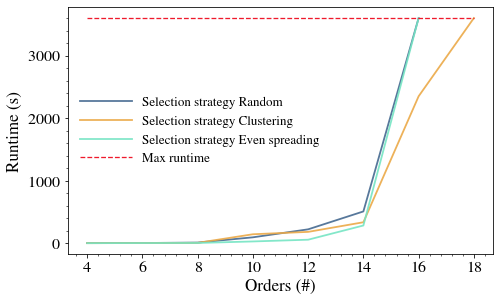

In [236]:
plot_ss_runtime()

## Weather scenario

### Weather scenario runtime

In [237]:
ws_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-C1-V1-WS0,4,1,2,1,Random,0.000000e+00,7438,7402,0.6901,0.6869
1,O4-C2-V1-WS0,4,1,2,1,Random,0.000000e+00,5704,5668,0.7464,0.2344
2,O4-C3-V1-WS0,4,1,2,1,Random,0.000000e+00,10612,10576,0.8865,0.8492
3,O4-C4-V1-WS0,4,1,2,1,Random,0.000000e+00,7094,7058,0.6631,0.7944
4,O6-C1-V1-WS0,6,1,3,1,Random,0.000000e+00,15040,14992,1.7319,1.8183
...,...,...,...,...,...,...,...,...,...,...,...
99,O24-C4-V3-WS2,24,3,12,3,Random,8.114798e-08,130652,130340,18.8300,1493.3194
100,O26-C1-V4-WS2,26,4,13,3,Random,9.040202e-02,204260,203840,26.6618,3600.1665
101,O26-C2-V4-WS2,26,4,13,3,Random,4.966498e-02,189720,189300,26.7079,3600.5453
102,O26-C3-V4-WS2,26,4,13,3,Random,5.807192e-02,198835,198415,28.2613,3600.1745


#### Weather scenario Low aggregated runtime

In [238]:
ws2_agg_runtime_df

,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,
4,0.000000,6417,6381,0.598625,0.569275
6,0.000000,16255,16207,1.466625,2.033900
8,0.000000,30071,30011,2.624500,8.423225
10,0.000000,71188,71080,5.991500,74.723225
12,0.000000,106260,106134,8.739800,147.978025
14,0.000000,148131,147987,11.983300,446.852950
16,0.108653,267738,267522,21.026750,3600.392825


#### Weather scenario High aggregated runtime

In [239]:
ws3_agg_runtime_df

,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,
4,0.000000e+00,1597,1561,0.209625,0.112975
6,0.000000e+00,3826,3778,0.558025,0.261300
8,0.000000e+00,7050,6990,0.974225,0.608850
10,0.000000e+00,16206,16098,2.422925,3.990275
12,0.000000e+00,24296,24170,3.612675,7.117250
14,0.000000e+00,33155,33011,4.815125,14.245775
16,0.000000e+00,58643,58427,8.468750,87.993275
18,0.000000e+00,72736,72496,10.747525,88.542900
20,7.887309e-08,91167,90903,13.011300,512.492700


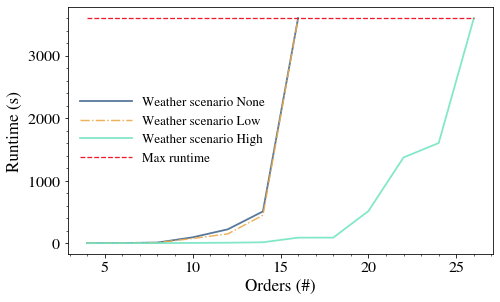

In [240]:
plot_ws_runtime()

### Weather scenario solutions

In [241]:
ws_solutions_df

,Instance name,Orders,Serviced,Postponed,Vessels,Fleet,Chartered,Weather,Selection,Fuel costs,Charter costs,Penalty costs,Objective bound
0,O4-C1-V1-WS0,4,4,0,1,1,0,1,Random,1768.4317,0.0,0.0000,1768.4317
1,O4-C1-V1-WS1,4,4,0,1,1,0,2,Random,1969.1458,0.0,0.0000,1969.1458
2,O4-C1-V1-WS2,4,4,0,1,1,0,3,Random,2344.5188,0.0,0.0000,2344.5188
3,O4-C2-V1-WS0,4,4,0,1,1,0,1,Random,2079.8900,0.0,0.0000,2079.8900
4,O4-C2-V1-WS1,4,4,0,1,1,0,2,Random,2337.0691,0.0,0.0000,2337.0691
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,O24-C4-V3-WS2,24,24,0,3,3,0,3,Random,9013.9983,0.0,0.0000,9013.9975
100,O26-C1-V4-WS2,26,26,0,4,4,0,3,Random,8714.0725,0.0,0.0012,7791.4333
101,O26-C2-V4-WS2,26,26,0,4,3,0,3,Random,9244.5858,0.0,0.0024,8712.6612
102,O26-C3-V4-WS2,26,26,0,4,4,0,3,Random,9342.5180,0.0,0.0003,8718.2799


#### Weather scenario aggregated solutions

In [242]:
ws_agg_solutions_df

Serviced  Postponed  Fleet  Chartered   Fuel costs  \
Orders Weather                                                       
4      1            4.00       0.00   1.00          0  1967.899175   
       2            4.00       0.00   1.00          0  2239.938750   
       3            4.00       0.00   1.00          0  2457.068700   
6      1            6.00       0.00   1.00          0  2187.146675   
       2            6.00       0.00   1.00          0  2570.672250   
       3            6.00       0.00   1.00          0  2945.771925   
8      1            8.00       0.00   1.00          0  2352.492725   
       2            8.00       0.00   1.00          0  2798.802925   
       3            7.75       0.25   1.00          0  3355.687325   
10     1           10.00       0.00   2.00          0  3523.959375   
       2           10.00       0.00   2.00          0  4082.232725   
       3           10.00       0.00   2.00          0  4696.206875   
12     1           12.00       0.00   2.00          0  3726.512700   
       2           12.00       0.00   2.00          0  4405.660350   
       3           12.00       0.00   1.75          0  4595.049600   
14     1           14.00       0.00   2.00          0  3969.810800   
       2           14.00       0.00   2.00          0  4765.321850   
       3           14.00       0.00   2.00          0  5460.032850   
16     1           16.00       0.00   2.25          0  4565.704850   
       2           16.00       0.00   2.25          0  5464.516850   
       3           16.00       0.00   2.25          0  6210.325900   
18     3           18.00       0.00   3.00          0  7172.964575   
20     3           20.00       0.00   3.00          0  7398.373725   
22     3           22.00       0.00   3.00          0  8212.561550   
24     3           23.50       0.50   3.00          0  8697.752950   
26     3           26.00       0.00   3.50          0  9073.337350   

                Charter costs  Penalty costs  Objective bound  
Orders Weather                                                 
4      1                  0.0       0.000000      1967.899175  
       2                  0.0       0.000000      2239.938750  
       3                  0.0       0.000000      2457.068700  
6      1                  0.0       0.000000      2187.146675  
       2                  0.0       0.000000      2570.672250  
       3                  0.0       0.000000      2945.771925  
8      1                  0.0       0.000000      2352.492725  
       2                  0.0       0.000000      2798.802925  
       3                  0.0     897.163525      4252.850850  
10     1                  0.0       0.000000      3523.959350  
       2                  0.0       0.000000      4082.232725  
       3                  0.0       0.000000      4696.206875  
12     1                  0.0       0.000475      3726.512225  
       2                  0.0       0.000525      4405.659825  
       3                  0.0       0.000250      4595.049350  
14     1                  0.0       0.000525      3969.810275  
       2                  0.0       0.000225      4765.321775  
       3                  0.0       0.000375      5460.032525  
16     1                  0.0       0.001100      3859.869625  
       2                  0.0       0.001125      4784.166175  
       3                  0.0       0.000950      6210.324950  
18     3                  0.0       0.000875      7172.963700  
20     3                  0.0       0.000475      7398.372600  
22     3                  0.0       0.000550      8212.560125  
24     3                  0.0     767.471200      9465.222725  
26     3                  0.0       0.001375      8362.845125

## Speed optimization

### Speed optimization runtime

In [14]:
nso_runtime_df

,Instance name,Orders,Vessels,Installations,Weather,Selection,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
0,O4-C1-V1-WS0,4,1,2,1,Random,0.000000,4186,4150,0.2624,0.4326
1,O4-C2-V1-WS0,4,1,2,1,Random,0.000000,2808,2772,0.2645,0.1789
2,O4-C3-V1-WS0,4,1,2,1,Random,0.000000,4244,4208,0.2538,0.2900
3,O4-C4-V1-WS0,4,1,2,1,Random,0.000000,3978,3942,0.2384,0.2981
4,O6-C1-V1-WS0,6,1,3,1,Random,0.000000,6864,6816,0.5658,0.9346
5,O6-C2-V1-WS0,6,1,3,1,Random,0.000000,6698,6650,0.5638,0.6782
6,O6-C3-V1-WS0,6,1,3,1,Random,0.000000,8752,8704,0.5709,1.1825
7,O6-C4-V1-WS0,6,1,3,1,Random,0.000000,8382,8334,0.5484,0.9446
8,O8-C1-V1-WS0,8,1,4,1,Random,0.000000,12520,12460,0.9935,3.8901
9,O8-C2-V1-WS0,8,1,4,1,Random,0.000000,12106,12046,0.9910,2.3483


In [15]:
nso_agg_runtime_df

,Optimality gap,Variables,Arcs,Preprocess runtime,Model runtime
Orders,,,,,
4,0.000000,3804,3768,0.254775,0.299900
6,0.000000,7674,7626,0.562225,0.934975
8,0.000000,13390,13330,1.019100,3.171475
10,0.000000,30127,30019,2.287850,33.893225
12,0.000000,43653,43527,3.521350,58.635800
14,0.000000,59558,59414,4.627575,117.968025
16,0.000000,103174,102958,7.874125,732.460850
18,0.023978,128152,127912,9.990475,2248.531200
20,0.101162,159232,158968,12.465000,3600.333600


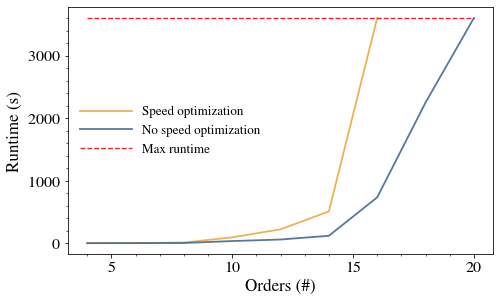

In [25]:
plot_nso_runtime()